In [1]:
import sys; sys.path.append('/home/clair/wwa'); from wwa import *

- consider also looking at 3-day or 5-day rolling average of tmean (then take max over ?DJF)

### **Preparatory**

#### **Merge ERA5 latest with climate explorer data**

In [34]:
jan = xr.open_dataset("../../Data/adaptor.mars.internal-1673256565.6084712-11171-12-07f53cff-bf16-449d-8334-e64ebaa4f05b.nc").rename(longitude = "lon", latitude = "lat")
jan_tx = convert_units_to(jan.mx2t.resample(time = "D").max(), "degC").resample(time = "MS").max()
jan_tn = convert_units_to(jan.mn2t.resample(time = "D").min(), "degC").resample(time = "MS").max()

In [ ]:
era5_tx = decode_times(xr.open_dataset("../../Data/era5_tmax_daily_eu_-10-20E_35-55N_su.62f4b5a82fde776a4c64f0ca33646aa0.info_12_max_70.nc", decode_times = False)).max_tmax
era5_tx = xr.concat([era5_tx, jan_tx], "time")
era5_tx.assign_attrs(notes = "Daily data up to & including January 3rd").to_netcdf("era5_maxtmax_monthly.nc")

TypeError: The DType <class 'numpy.dtype[datetime64]'> could not be promoted by <class 'numpy.dtype[int64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[int64]'>)

In [ ]:
era5_tn = decode_times(xr.open_dataset("../../Data/era5_tmin_daily_eu_-10-20E_35-55N_su.62f4b5a82fde776a4c64f0ca33646aa0.info_12_max_70.nc", decode_times = False)).max_tmin
era5_tn = xr.concat([era5_tn, jan_tn], "time")
era5_tn.assign_attrs(notes = "Daily data up to & including January 3rd").to_netcdf("era5_maxtmin_monthly.nc")

#### **Prep time series for fitting in R**

In [113]:
# Daily max temperatures
da = xr.open_dataset("era5_maxtmax_monthly.nc").max_tmax
lsm = xr.open_dataset("../../Data/era5_000000_lsm_eu.nc").squeeze(drop = True).sel(longitude = da.lon, latitude = da.lat).lsm
da = da.where(lsm >= 0.5).dropna("lat", "all").dropna("lon", "all").dropna("time", "all")

# flatten January maxima into DataFrame for processing in R
da_jan = da.groupby("time.month")[1]
da_jan = da_jan.assign_coords(time = da_jan.time.dt.year)
da_jan.stack(xy = ["lat", "lon"]).to_pandas().to_csv("fitted-models/era5_Jan-tmax_flattened.csv")

# also July data, for direct comparison of change in summer vs winter heatwaves
da_jul = da.groupby("time.month")[7]
da_jul = da_jul.assign_coords(time = da_jul.time.dt.year)
da_jul.stack(xy = ["lat", "lon"]).to_pandas().to_csv("fitted-models/era5_Jul-tmax_flattened.csv")

In [5]:
# Daily min temperatures
da = xr.open_dataset("era5_maxtmin_monthly.nc").max_tmin
lsm = xr.open_dataset("../../Data/era5_000000_lsm_eu.nc").squeeze(drop = True).sel(longitude = da.lon, latitude = da.lat).lsm
da = da.where(lsm >= 0.5).dropna("lat", "all").dropna("lon", "all").dropna("time", "all")

# flatten January maxima into DataFrame for processing in R
da_jan = da.groupby("time.month")[1]
da_jan = da_jan.assign_coords(time = da_jan.time.dt.year)
da_jan.stack(xy = ["lat", "lon"]).to_pandas().to_csv("fitted-models/era5_Jan-tmin_flattened.csv")

# also July data, for direct comparison of change in summer vs winter heatwaves
da_jul = da.groupby("time.month")[7]
da_jul = da_jul.assign_coords(time = da_jul.time.dt.year)
da_jul.stack(xy = ["lat", "lon"]).to_pandas().to_csv("fitted-models/era5_Jul-tmin_flattened.csv")

In [62]:
# ML estimation is carried out in R

---
### **Maximum January & July temperatures**

In [165]:
# load fitted models, reshape into dataset for easier plotting

lsm = xr.open_dataset("../../Data/era5_000000_lsm_eu.nc").squeeze(drop = True).sel(longitude = slice(-10,20), latitude = slice(55,35)).lsm.rename(longitude = "lon", latitude = "lat")

jan_tmax = reshape_df("fitted-models/era5-eu_tx1x-Jan_shift_ml-gev-ests.csv", lsm)
jul_tmax = reshape_df("fitted-models/era5-eu_tx1x-Jul_shift_ml-gev-ests.csv", lsm)

# replace infinite values with high value so that they actually appear on the plot
jan_tmax["pr"] = xr.concat([jan_tmax.pr.where(jan_tmax.pr < 10e5), xr.ones_like(jan_tmax.pr).where(jan_tmax.pr >= 10e5) * 10e5], "new").sum("new")
jan_tmax["pr"] = jan_tmax.pr.where(jan_tmax.pr > 0)

jul_tmax["pr"] = xr.concat([jul_tmax.pr.where(jul_tmax.pr < 10e5), xr.ones_like(jul_tmax.pr).where(jul_tmax.pr >= 10e5) * 10e5], "new").sum("new")
jul_tmax["pr"] = jul_tmax.pr.where(jul_tmax.pr > 0)

#### **Parameter estimates**

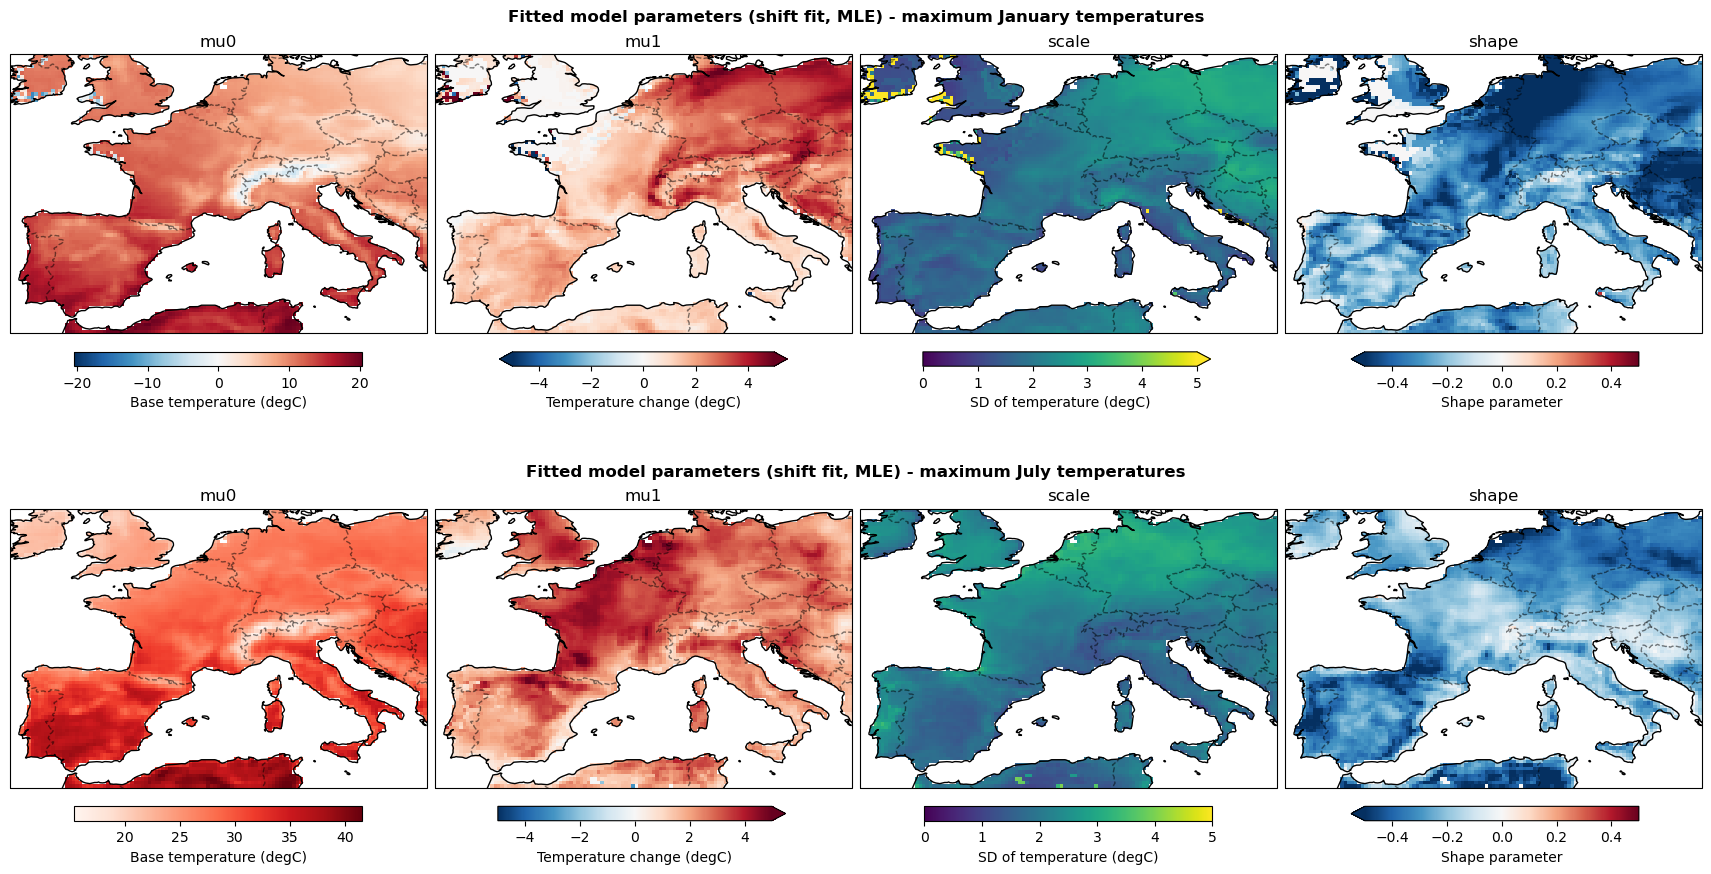

In [103]:
fig = plt.figure(constrained_layout = True, figsize = (17,9), dpi = 100)
sfig = fig.subfigures(nrows = 2, ncols = 1)

cbar_kwargs = {"location" : "bottom", "fraction" : 0.04, "pad" : 0.05, "shrink" : 0.85}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

sfig[0].suptitle("Fitted model parameters (shift fit, MLE) - maximum January temperatures", fontweight = "bold", y = 0.91)
axs = sfig[0].subplots(ncols = 4, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})

jan_tmax.mu0.plot(ax = axs[0], cbar_kwargs = cbar_kwargs | {"label" : "Base temperature (degC)"}); axs[0].set_title("mu0")
jan_tmax.mu1.plot(ax = axs[1], cbar_kwargs = cbar_kwargs | {"label" : "Temperature change (degC)"}, vmax = 5); axs[1].set_title("mu1")
jan_tmax.sigma0.plot(ax = axs[2], cbar_kwargs = cbar_kwargs | {"label" : "SD of temperature (degC)"}, vmin = 0, vmax = 5); axs[2].set_title("scale")
jan_tmax.shape.plot(ax = axs[3], cbar_kwargs = cbar_kwargs | {"label" : "Shape parameter"}, vmin = -0.5); axs[3].set_title("shape")

for ax in axs:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.5)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

sfig[1].suptitle("Fitted model parameters (shift fit, MLE) - maximum July temperatures", fontweight = "bold", y = 0.91)
axs = sfig[1].subplots(ncols = 4, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})

jul_tmax.mu0.plot(ax = axs[0], cmap = "Reds", cbar_kwargs = cbar_kwargs | {"label" : "Base temperature (degC)"}); axs[0].set_title("mu0")
jul_tmax.mu1.plot(ax = axs[1], cbar_kwargs = cbar_kwargs | {"label" : "Temperature change (degC)"}, vmax = 5); axs[1].set_title("mu1")
jul_tmax.sigma0.plot(ax = axs[2], cbar_kwargs = cbar_kwargs | {"label" : "SD of temperature (degC)"}, vmin = 0, vmax = 5); axs[2].set_title("scale")
jul_tmax.shape.plot(ax = axs[3], cbar_kwargs = cbar_kwargs | {"label" : "Shape parameter"}, vmin = -0.5); axs[3].set_title("shape")

for ax in axs:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.5)

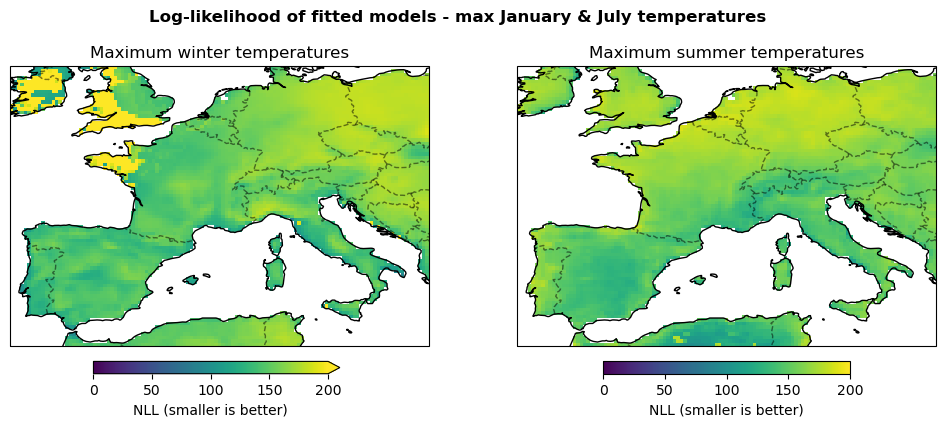

In [108]:
# local model fit
fig, axs = plt.subplots(ncols = 2, figsize = (12,4), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})

kwargs = {"vmin" : 0, "vmax" : 200, "cbar_kwargs" : {"location" : "bottom", "fraction" : 0.04, "pad" : 0.05, "shrink" : 0.85, "label" : "NLL (smaller is better)"}}

jan_tmax.nll.plot(ax = axs[0], **kwargs)
jul_tmax.nll.plot(ax = axs[1], **kwargs)

axs[0].set_title("Maximum winter temperatures")
axs[1].set_title("Maximum summer temperatures")

plt.suptitle("Log-likelihood of fitted models - max January & July temperatures", fontweight = "bold", y = 1.02)

for ax in axs:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.5)

#### **Estimated exceedances & return periods**

In [168]:
fig = plt.figure(constrained_layout = True, figsize = (17,9), dpi = 100)
sfig = fig.subfigures(nrows = 2, ncols = 1)

cbar_kwargs = {"location" : "bottom", "fraction" : 0.04, "pad" : 0.05, "shrink" : 0.85}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

sfig[0].suptitle("Exceedance probabilities & return periods (shift fit, MLE) - January 2023 event", fontweight = "bold", y = 0.94)
axs = sfig[0].subplots(ncols = 4, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})

jan_tmax.ep.plot(ax = axs[0], vmin = 0, vmax = 1, cbar_kwargs = cbar_kwargs | {"label" : "Probability"}); axs[0].set_title("Exceedance probability")
jan_tmax.rp.plot(ax = axs[1], vmin = 1, vmax = 1000, norm = matplotlib.colors.LogNorm(), 
                 cbar_kwargs = cbar_kwargs | {"label" : "Return period (years)", "format" : lambda x, _: f"{x}"}); axs[1].set_title("Return period")
jan_tmax.pr.plot(ax = axs[2], vmin = 10e-3, vmax = 10e1, norm = matplotlib.colors.LogNorm(), cmap = "PiYG", 
                 cbar_kwargs = cbar_kwargs | {"label" : "Probability ratio"}); axs[2].set_title("Probability ratio (1.2deg GMST)")
jan_tmax.delta_I.plot(ax = axs[3], vmax = 5, cbar_kwargs = cbar_kwargs | {"label" : "degC"}); axs[3].set_title("Change in intensity (1.2 degC GMST)")

for ax in axs:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.5)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

sfig[1].suptitle("Exceedance probabilities & return periods (shift fit, MLE) - July 2022 event", fontweight = "bold", y = 0.94)
axs = sfig[1].subplots(ncols = 4, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})

jul_tmax.ep.plot(ax = axs[0], vmin = 0, vmax = 1, cbar_kwargs = cbar_kwargs | {"label" : "Probability"}); axs[0].set_title("Exceedance probability")
jul_tmax.rp.plot(ax = axs[1], vmin = 1, vmax = 1000, norm = matplotlib.colors.LogNorm(), 
                 cbar_kwargs = cbar_kwargs | {"label" : "Return period (years)", "format" : lambda x, _: f"{x}"}); axs[1].set_title("Return period")
jul_tmax.pr.plot(ax = axs[2], vmin = 10e-3, vmax = 10e1, norm = matplotlib.colors.LogNorm(), cmap = "PiYG", 
                 cbar_kwargs = cbar_kwargs | {"label" : "Probability ratio"}); axs[2].set_title("Probability ratio (1.2deg GMST)")
jul_tmax.delta_I.plot(ax = axs[3], vmax = 5, cbar_kwargs = cbar_kwargs | {"label" : "degC"}); axs[3].set_title("Change in intensity (1.2 degC GMST)")

for ax in axs:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.5)
    
plt.savefig("return-period-map_EU_Jan-Jul.png")

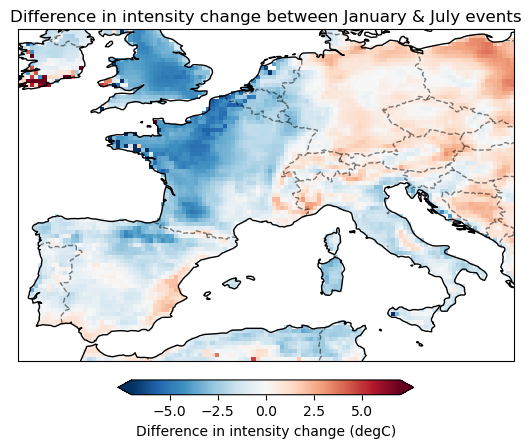

In [178]:
(jan_tmax - jul_tmax).delta_I.plot(vmin = -5, vmax = 5, cmap = "RdBu_r", subplot_kws = {"projection" : cartopy.crs.PlateCarree()},
                                  cbar_kwargs = cbar_kwargs | {"label" : "Difference in intensity change (degC)"})
ax = plt.gcf().axes[0]
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.5)

ax.set_title("Difference in intensity change between January & July events")
plt.savefig("difference-in-intensity.png")

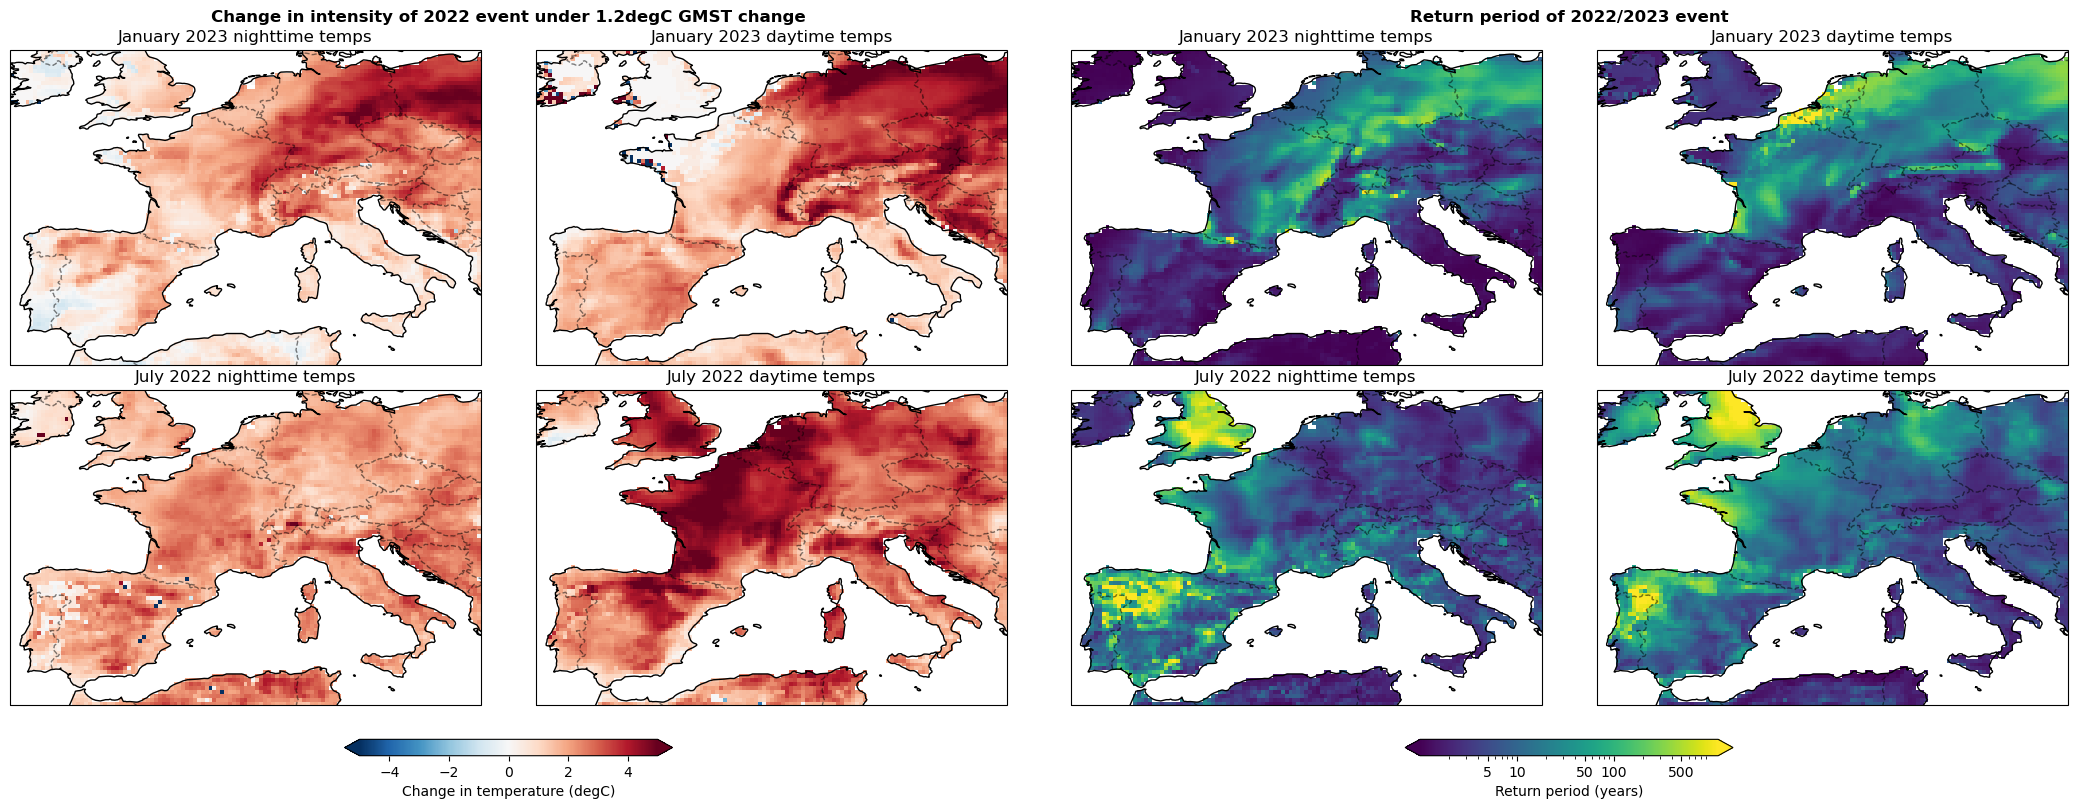

In [18]:
fig = plt.figure(constrained_layout = True, figsize = (21,8), dpi = 100)
sfig = fig.subfigures(nrows = 1, ncols = 2)

cbar_kwargs = {"location" : "bottom", "fraction" : 0.025, "pad" : 0.05, "shrink" : 0.85}
int_kwargs = {"add_colorbar" : False, "vmax" : 5}
rp_kwargs = {"add_colorbar" : False,  "norm" : matplotlib.colors.LogNorm(), "vmin" : 1, "vmax" : 1200}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

sfig[0].suptitle("Change in intensity of 2022 event under 1.2degC GMST change", fontweight = "bold")
axs = sfig[0].subplots(ncols = 2, nrows = 2, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})

jan_tmin.delta_I.plot(ax = axs[0,0], **int_kwargs); axs[0,0].set_title("January 2023 nighttime temps")
jan_tmax.delta_I.plot(ax = axs[0,1], **int_kwargs); axs[0,1].set_title("January 2023 daytime temps")

jul_tmin.delta_I.plot(ax = axs[1,0], **int_kwargs); axs[1,0].set_title("July 2022 nighttime temps")
int_cbar = jul_tmax.delta_I.plot(ax = axs[1,1], **int_kwargs); axs[1,1].set_title("July 2022 daytime temps")

plt.colorbar(int_cbar, ax = axs, **cbar_kwargs | {"label" : "Change in temperature (degC)"}, extend = "both")

for i in range(2):
    for ax in axs[i,:]:
        ax.coastlines()
        ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.5)
        
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

sfig[1].suptitle("Return period of 2022/2023 event", fontweight = "bold")
axs = sfig[1].subplots(ncols = 2, nrows = 2, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})

jan_tmin.rp.plot(ax = axs[0,0], **rp_kwargs); axs[0,0].set_title("January 2023 nighttime temps")
jan_tmax.rp.plot(ax = axs[0,1], **rp_kwargs); axs[0,1].set_title("January 2023 daytime temps")
jul_tmin.rp.plot(ax = axs[1,0], **rp_kwargs); axs[1,0].set_title("July 2022 nighttime temps")
rp_cbar = jul_tmax.rp.plot(ax = axs[1,1], **rp_kwargs); axs[1,1].set_title("July 2022 daytime temps")

plt.colorbar(rp_cbar, ax = axs, **cbar_kwargs, label = "Return period (years)", ticks = [5,10,50,100,500], format = lambda x, _: f"{x}", extend = "both")

for i in range(2):
    for ax in axs[i,:]:
        ax.coastlines()
        ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.5)
        
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

plt.savefig("jan-vs-july-hw-change.png")